# Chapter24: 分類法
- one-class learning: トレーニングデータは1つのクラスから抽出した標本の集合。そのクラスに属するか否かで分類。異常検知器とか。
- two-class learning: binary classificationとも呼ばれる。陰性と陽性を分類する境界を見つけることが目的。
- multi-class learning: 3つ以上のクラスを互いに分類するためにの境界を見つけること。
## 24.1: 分類の評価


In [25]:
# code 24.1 分類器評価のための関数
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg # 真陽性 ＋ 真陰性
    denominator = truePos + trueNeg + falsePos + falseNeg # 真陽性 + 真陰性 + 偽陽性 + 偽陰性
    return numerator/denominator # 真陽性 ＋ 真陰性 /(全データ)

def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')

def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg+falsePos)
    except ZeroDivisionError:
        return float('nan')

def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')

def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')

def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint=True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print('Accuracy =', round(accur,3))
        print('sensitivity =',round(sens,3))
        print('specificity =', round(spec,3))
        print('pos. Pred. Val. =',round(ppv,3))
    return (accur,sens,spec,ppv)

## 24.2 ランナーの性別予想

In [26]:
# 17.2
def getBMData(filename):
    """与えられたファイルの内容を読み込む、
       ファイルは次の6要素がカンマで区切られた形式
       0. 氏名(string), 1. 性別(string), 2. 年齢(int), 3. 区分(走/車いす),4. 出身国(string),5. 総合タイム(float)
       返り値: それぞれが6変数のリストのdict(辞書)"""
    data = {}
    f = open(filename)
    line = f.readline()
    data['name'],data['gender'],data['age'] = [],[],[] # 辞書要素をリストで初期化
    data['division'],data['country'],data['time'] = [],[],[]
    while line != '': # 最終行まで読み込む
        split = line.split(',') # カンマで区切りリストで返す
        data['name'].append(split[0])
        data['gender'].append(split[1])
        data['age'].append(float(split[2]))
        data['division'].append(split[3])
        data['country'].append(split[4])
        data['time'].append(float(split[5][:-1])) # 改行\nを取り除く
        line = f.readline()
    f.close()
    return data

In [27]:
# 24.2 標本作成とトレーニングデータ、テストデータへの分割
class Runner(object):
    def __init__(self, gender, age, time):
        self.featureVec = (age,time)
        self.label = gender
    
    def featureDist(self, other):
        dist = 0.0
        for i in range(len(self.featureVec)):
            dist += abs(self.featureVec[i] - other.featureVec[i])**2
        return dist**0.5
    
    def getTime(self):
        return self.featureVec[1]
    
    def getAge(self):
        return self.featureVec[0]
    
    def getLabel(self):
        return self.label
    
    def getFeatures(self):
        return self.featureVec
    
    def __str__(self):
        return str(self.getAge()) + ', ' + str(self.getTime()) + ', ' + self.label
    
def buildMarathonExamples(fileName):
    data = getBMData(fileName)
    examples = []
    for i in range(len(data['age'])):
        a = Runner(data['gender'][i], data['age'][i], data['time'][i])
        examples.append(a)
    return examples

import random
def divide80_20(examples):
    sampleIndices = random.sample(range(len(examples)), len(examples)//5) # (80, 20)
    trainingSet, testSet = [],[]
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

- トレーニングデータ全体の58%のランナーが男性。
- すべてのランナーを男性と予想すれば58％のaccuracyを期待できる⇒基準線として意識する

In [28]:
# k-近傍法
def findKNearest(example, exampleSet, k):
    kNearest, distances = [],[]
    # 最初のk個の標本からなるリストと、それらのexampleの距離のリストを作る
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.featureDist(exampleSet[i]))
    maxDist = max(distances) # Get maximum distance
    # まだ考えられていないexampleSetの標本に対して
    for e in exampleSet[k:]:
        dist = example.featureDist(e)
        if dist < maxDist:
            # 最も遠い距離にある標本を、標本eで置換
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)
    return kNearest, distances

def KNearestClassify(training, testSet, label, k):
    """training, testSet: 標本のリスト
       k：　整数と仮定
       label: ラベル
       testSetの標本が、与えられたlabelをもつ標本のなのかどうかを
       k-近傍分類器を使用して予測。
       返り値: true positive, false positive, true negagive, false nagativeの標本数を返す"""
    truePos, falsePos, trueNeg, falseNeg = 0,0,0,0
    for e in testSet:
        nearest, distances = findKNearest(e, training, k)
        # 投票を行う
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: # 判断はラベルと同じ
            if e.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: # 判断はラベルと異なる
            if e.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

In [29]:
# training data に対しての各精度
import random
examples = buildMarathonExamples('bm_results2012.txt')
training, testSet = divide80_20(examples)
truePos, falsePos, trueNeg, falseNeg = KNearestClassify(training, testSet, 'M', 9)
getStats(truePos, falsePos, trueNeg,falseNeg) 

Accuracy = 0.671
sensitivity = 0.724
specificity = 0.597
pos. Pred. Val. = 0.714


(0.6710770659238626,
 0.7243717590745912,
 0.5968906163242643,
 0.7143981117230527)

In [9]:
examples = buildMarathonExamples('bm_results2012.txt')

In [18]:
features = examples[0].getFeatures()
type(features[0])

float

In [30]:
# 24.4 有病率ベースの分類器
def prevalenceClassify(training, testSet, label):
    """training, testSet: 標本のリスト
       testSetとそれぞれの標本ラベルが、クラスラベルと同じかどうか、
       prevalence-based分類器を使用して予測する.
       返り値：true positive, false positive, false positive, false negativeの数を返す"""
    numWithLabel = 0
    for e in training:
        if e.getLabel() == label:
            numWithLabel += 1
    probLabel = numWithLabel/len(training)
    truePos, falsePos, trueNeg, falseNeg = 0,0,0,0
    for e in testSet:
        if random.random() < probLabel: # eがlabelクラスであると判断
            if e.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: # eがlabelクラスでないと判断
            if e.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

In [31]:
examples = buildMarathonExamples('bm_results2012.txt')
training, testSet = divide80_20(examples)
truePos, falsePos, trueNeg, falseNeg = prevalenceClassify(training, testSet, 'M')
getStats(truePos, falsePos, trueNeg, falseNeg)

Accuracy = 0.516
sensitivity = 0.593
specificity = 0.409
pos. Pred. Val. = 0.581


(0.515552460538533, 0.5928742994395516, 0.4088397790055249, 0.5805566444531556)

In [33]:
reducedTraining = random.sample(training, len(training)//10)
truePos, falsePos, trueNeg, falseNeg = KNearestClassify(reducedTraining, testSet, 'M', 9)
getStats(truePos, falsePos, trueNeg, falseNeg)

Accuracy = 0.651
sensitivity = 0.735
specificity = 0.536
pos. Pred. Val. = 0.686


(0.6513463324048282, 0.7345876701361089, 0.53646408839779, 0.6862378459237098)

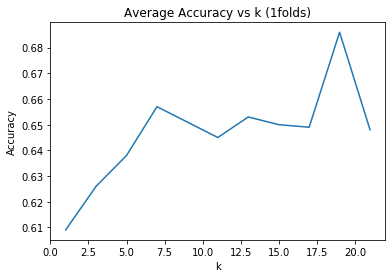

In [37]:
# 24.5 良いkを探す
import pylab

def findK(training, minK, maxK, numFolds, label):
    # ある値の範囲の奇数kに対する平均正確度を計算する
    accuracies = []
    for k in range(minK, maxK+1, 2):
        score = 0.0
        for i in range(numFolds):
            # 計算時間を削減するためのダウンサンプル
            fold = random.sample(training, min(5000,len(training)))
            examples, testSet = divide80_20(fold)
            truePos, falsePos, trueNeg, falseNeg = KNearestClassify(examples, testSet, label, k)
            score += accuracy(truePos, falsePos, trueNeg, falseNeg)
        accuracies.append(score/numFolds)
    pylab.plot(range(minK,maxK+1,2),accuracies)
    pylab.title('Average Accuracy vs k (' + str(numFolds) + 'folds)')
    pylab.xlabel('k')
    pylab.ylabel('Accuracy')

findK(training,1,21,1,'M')

## 回帰をもとにした分類器
- 線形回帰を利用してモデルを作成する
- 男性と女性別々のモデルを作る

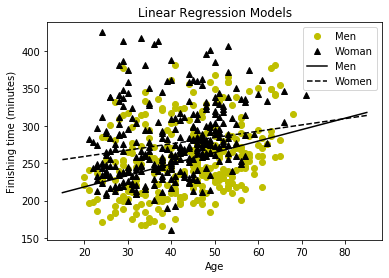

In [39]:
# 24.6 線形回帰モデルの生成と作図
# 男性、女性別にトレーニングデータセットを作成する
ageM, ageW, timeM, timeW = [],[],[],[]
for e in training:
    if e.getLabel() == 'M':
        ageM.append(e.getAge())
        timeM.append(e.getTime())
    else:
        ageW.append(e.getAge())
        timeW.append(e.getTime())
# プロットを見やすくするためにダウンサンプルをする
ages, times = [],[]
for i in random.sample(range(len(ageM)),300):
    ages.append(ageM[i])
    times.append(timeM[i])
# 標本の散布図を作成する
pylab.plot(ages, times, 'yo', markersize=6, label='Men')
ages, times = [],[]
for i in random.sample(range(len(ageW)),300):
    ages.append(ageW[i])
    times.append(timeW[i])
pylab.plot(ages, times, 'k^', markersize=6, label='Woman')
# 2つの、1次線形回帰モデルを学習する
mModel = pylab.polyfit(ageM, timeM, 1)
fModel = pylab.polyfit(ageW, timeW, 1)
# モデルに対応した直線をプロットする
xmin, xmax = 15,85
pylab.plot((xmin, xmax), (pylab.polyval(mModel,(xmin,xmax))), 'k', label='Men')
pylab.plot((xmin, xmax), (pylab.polyval(fModel,(xmin,xmax))), 'k--', label='Women')
pylab.title('Linear Regression Models')
pylab.xlabel('Age')
pylab.ylabel('Finishing time (minutes)')
pylab.legend()

In [41]:
truePos, falsePos, trueNeg, falseNeg = 0,0,0,0
for e in testSet:
    age = e.getAge()
    time = e.getTime()
    if abs(time - pylab.polyval(mModel,age)) < abs(time-pylab.polyval(fModel, age)):
        if e.getLabel() == 'M':
            truePos += 1
        else:
            falsePos += 1
    else:
        if e.getLabel() == 'F':
            trueNeg += 1
        else:
            falseNeg += 1
getStats(truePos, falsePos, trueNeg, falseNeg)

Accuracy = 0.615
sensitivity = 0.676
specificity = 0.53
pos. Pred. Val. = 0.665


(0.6149025069637883, 0.6761409127301842, 0.5303867403314917, 0.665222528554549)

結果はランダム(58%?)より良いが、k-近傍法よりやや悪い。

In [43]:
# 24.8 sklearnを用いた多クラスロジスティック回帰
import sklearn.linear_model

featureVecs, labels = [],[]
for i in range(25000): # それぞれの繰り返しで、4つ標本を作成する
    featureVecs.append([random.gauss(0,0.5), random.gauss(0,0.5),random.random()])
    labels.append('A')
    featureVecs.append([random.gauss(0,0.5), random.gauss(2,0.),random.random()])
    labels.append('B')
    featureVecs.append([random.gauss(2,0.5), random.gauss(0,0.5),random.random()])
    labels.append('C')
    featureVecs.append([random.gauss(2,0.5), random.gauss(2,0.5),random.random()])
    labels.append('D')
model = sklearn.linear_model.LogisticRegression().fit(featureVecs, labels)
print('model.classes_ = ', model.classes_)
for i in range(len(model.coef_)):
    print('For label', model.classes_[i],'feature weights =', model.coef_[i])
print('[0,0] probs =', model.predict_proba([[0,0,1]])[0])
print('[0,2] probs =', model.predict_proba([[0,2,2]])[0])
print('[2,0] probs =', model.predict_proba([[2,0,3]])[0])
print('[2,2] probs =', model.predict_proba([[2,2,4]])[0])

model.classes_ =  ['A' 'B' 'C' 'D']
For label A feature weights = [-4.66519399 -4.4323871   0.04456426]
For label B feature weights = [-5.16962011  5.85338783 -0.10361956]
For label C feature weights = [ 3.88810085 -3.91167755  0.07314815]
For label D feature weights = [ 4.28931704  5.31034991 -0.17226209]
[0,0] probs = [9.88274126e-01 3.95620499e-04 1.13298888e-02 3.64952940e-07]
[0,2] probs = [8.99045240e-03 9.78611200e-01 4.91974707e-06 1.23934282e-02]
[2,0] probs = [6.05387111e-03 1.06073195e-08 9.92546193e-01 1.39992566e-03]
[2,2] probs = [8.83936101e-07 1.13941496e-03 1.34569215e-02 9.85402780e-01]


In [45]:
# 24.9 2クラスのロジスティック回帰
featureVecs, labels = [],[]
for i in range(20000):
    featureVecs.append([random.gauss(0,0.5), random.gauss(0, 0.5)])
    labels.append('A')
    featureVecs.append([random.gauss(2,0.5), random.gauss(2, 0.5)])
    labels.append('D')
model = sklearn.linear_model.LogisticRegression().fit(featureVecs, labels)
print('model.coef =', model.coef_)
print('[0,0] probs =' ,model.predict_proba([[0,0]])[0])
print('[0,2] probs =' ,model.predict_proba([[0,2]])[0])
print('[2,0] probs =' ,model.predict_proba([[2,0]])[0])
print('[2,2] probs =' ,model.predict_proba([[2,2]])[0])

model.coef = [[5.53898401 5.89279593]]
[0,0] probs = [9.99988779e-01 1.12206151e-05]
[0,2] probs = [0.40423612 0.59576388]
[2,0] probs = [0.57927029 0.42072971]
[2,2] probs = [1.04822863e-05 9.99989518e-01]


In [46]:
def applyModel(model, testSet, label, prob=0.5):
    # すべてのテストデータに対する特徴ベクトルからなるベクトルを作る
    testFeatureVecs = [e.getFeatures() for e in testSet]
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg= 0,0,0,0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

examples = buildMarathonExamples('bm_results2012.txt')
training, test = divide80_20(examples)

featureVecs, labels=[],[]
for e in training:
    featureVecs.append([e.getAge(), e.getTime()])
    labels.append(e.getLabel())
model = sklearn.linear_model.LogisticRegression().fit(featureVecs, labels)
print('Feature weights for label M:', 
        'age =', str(round(model.coef_[0][0],3)) + ',', 
        'time =', round(model.coef_[0][1],3))
truePos, falsePos, trueNeg, falseNeg = applyModel(model, test, 'M', 0.5)
getStats(truePos, falsePos, trueNeg, falseNeg)

Feature weights for label M: age = 0.056, time = -0.012
Accuracy = 0.635
sensitivity = 0.796
specificity = 0.403
pos. Pred. Val. = 0.658


(0.6353296193129062,
 0.7963836477987422,
 0.4030612244897959,
 0.6580058460539137)

- k-近傍法と比較して正確度と陽性適中率は同じくらいの精度
- ロジスティック回帰の方が、より高い感度、より低い特異度を持っている
    - このことが２つの方法の比較を難しくしている
        - appModelで使用される確率の閾値を調整することによって、この問題を解決することが可能

In [47]:
truePos, falsePos, trueNeg, falseNeg = applyModel(model, test, 'M', 0.578)
getStats(truePos, falsePos, trueNeg, falseNeg)

Accuracy = 0.648
sensitivity = 0.686
specificity = 0.593
pos. Pred. Val. = 0.709


(0.6480965645311049,
 0.6863207547169812,
 0.5929705215419501,
 0.7086038961038961)

- 同じような性能を持つ
- 線形回帰モデルの識別閾値を変更することの影響を探ることは簡単なので、感度と特異度のトレードオフを視覚化するために、受信者操作特性(Receiver Operating Charasteristic)曲線あるいはROC曲線と呼ばれるものを利用することができる。その曲線は、複数の識別閾値について偽陽性率(1-特異度)に対する真陽性率(感度)をプロットしたものである。
    - ROC曲線は、曲線の元の部分の面AUROC(Area Under ROC)を計算することによって、他の曲線と比較することができる。この面接は、モデルが、ランダムに選ばれた陰性の標本より、ランダムに選ばれた陽性の標本を陽性であると判断する確率と等しい。このことは、モデルの識別力として知られている。
        - 識別力は、確率の正確度（補正とよばれる）について何も言わないことに注意。例えば「、すべての推定された確率を2で割っても識別力は何も変化しないが、正確度は変化する。

0.6946546897060711

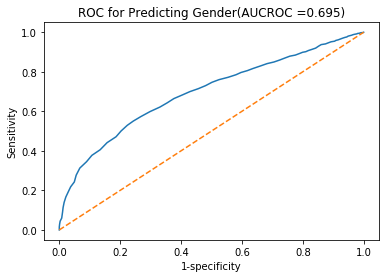

In [48]:
# 24.11 ROCカーブをプロットし、AUROCを求める
def buildROC(model, testSet, label, title, plot=True):
    xVals, yVals = [],[]
    p = 0.0
    while p <= 1.0:
        truePos, falsePos, trueNeg, falseNeg = applyModel(model, testSet, label, p)
        xVals.append(1.0 - specificity(trueNeg, falsePos))
        yVals.append(sensitivity(truePos, falseNeg))
        p += 0.01
    auroc = sklearn.metrics.auc(xVals, yVals, True)
    if plot:
        pylab.plot(xVals, yVals)
        pylab.plot([0,1],[0,1], '--')
        pylab.title(title + '(AUCROC =' + str(round(auroc,3)) + ')')
        pylab.xlabel('1-specificity')
        pylab.ylabel('Sensitivity')
    return auroc

buildROC(model, test, 'M', 'ROC for Predicting Gender')

## 24.5 タイタニック号からの生還

In [49]:
# 22.4
def minkowskiDist(v1, v2, p):
    """ v1とv2は長さの等しい数値配列であるとする
        v1とv2の、p次のミンコウスキ距離を返す。
        p = 1: マンハッタン距離
        p = 2: ユークリッド距離"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i]-v2[i])**p
    return dist**(1/p)

In [50]:
# 24.12 Passenger クラス
class Passeger(object):
    features = ('C1','C2','C3','age', 'male gender')
    def __init__(self, pClass, age, gender, survived, name):
        self.name = name
        self.featureVec = [0,0,0,age, gender]
        self.featureVec[pClass - 1] = 1
        self.label = survived
        self.cabinClass = pClass
    def distance(self, other):
        return minkowskiDist(self.featureVec, other.featureVec,2)
    def getClass(self):
        return self.cabinClass
    def getAge(self):
        return self.featureVec[3]
    def getGender(self):
        return self.featureVec[4]
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.featureVec[:]
    def getLabel(self):
        return self.label

In [52]:
def getTitanicData(fname):
    data = {}
    data['class'], data['survived'], data['age'] = [],[],[]
    data['gender'], data['name'] = [],[]
    f = open(fname)
    line = f.readline()
    while line != '':
        split = line.split(',')
        data['class'].append(int(split[0]))
        data['age'].append(int(split[1]))
        if split[2] == 'M':
            data['gender'].append(1)
        else:
            data['gender'].append(0)
        data['survived'].append(int(split[3])) # 1が生還
        data['name'].append(split[4:])
        line = f.readline()
    return data

def buildTitanicExamples(fileName):
    data = getTitanicData(fileName)
    examples = []
    for i in range(len(data['class'])):
        p = Passeger(data['class'][i],
                     data['age'][i],
                     data['gender'][i],
                     data['survived'][i],
                     data['name'][i])
        examples.append(p)
    return examples

In [54]:
def variance(X):
    """Xを数のリストとする。
       Xの分散を返す"""
    mean = sum(X)/len(X)
    tot = 0.0
    for x in X:
        tot += (x-mean)**2
    return tot/len(X)

def stdDev(X):
    """を数のリストとする。
       Xの標準偏差を返す。"""
    return variance(X)**0.5

In [55]:
def testModels(examples, numTrials, printStats, printWeights):
    stats, weights = [],[[],[],[],[],[]]
    for i in range(numTrials):
        training, testSet = divide80_20(examples)
        xVals, yVals = [],[]
        for e in training:
            xVals.append(e.getFeatures())
            yVals.append(e.getLabel())
        xVals = pylab.array(xVals)
        yVals = pylab.array(yVals)
        model = sklearn.linear_model.LogisticRegression().fit(xVals,yVals)
        for i in range(len(Passeger.features)):
            weights[i].append(model.coef_[0][i])
        truePos, falsePos, trueNeg, falseNeg = applyModel(model, testSet, 1, 0.5)
        auroc = buildROC(model, testSet, 1, None, False)
        tmp = getStats(truePos, falsePos, trueNeg, falseNeg, False)
        stats.append(tmp + (auroc,))
    print('Averages for', numTrials, 'trails')
    if printWeights:
        for feature in range(len(weights)):
            featureMean = sum(weights[feature])/numTrials
            featureStd = stdDev(weights[feature])
            print('Mean weight of', Passeger.features[feature], '=', str(round(featureMean, 3)) + ',', '95% confidence interval =', round(1.96*featureStd,3))
    if printStats:
        summarizeStats(stats)
        